Why is performance consistently so much better on the flu positivity task with the CNN Transformer?

In [14]:
from src.models.lablers import ClauseLabler, FluPosLabler
from src.data.utils import load_processed_table
import pandas as pd
from src.data.make_petastorm_dataset import spark_timezone
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

import pyspark.sql.types as sql_types
from pyspark.sql import functions as f
from pyspark.sql.functions import col

from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark import SparkContext

SPARK_CONFIG = [ 
    ("spark.master","local[32]"),
    ("spark.ui.port","4050"),
    ("spark.executor.memory","16g"),
    ('spark.driver.memory',  '64g'),
    ("spark.driver.maxResultSize", '0'), # unlimited
    ("spark.network.timeout",            "10000001"),
    ("spark.executor.heartbeatInterval", "10000000")]   

conf = SparkConf().setAll(SPARK_CONFIG)
sc = SparkContext(conf=conf, appName="PetaStorm Conversion")
spark = SparkSession(sc)

22/01/11 11:55:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
PROCESSED_DATA_LOCATION = "/projects/bdata/datasets/gatesfoundation/processed/split/audere_split_2020_02_10_to_2020_04_01/train_7_day_no_scale/"
with spark_timezone("UTC"):    
    processed_df = spark.read.parquet(PROCESSED_DATA_LOCATION)
processed_df = processed_df.withColumn("end",f.to_date("end"))
processed_df.printSchema()

root
 |-- participant_id: string (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- end: date (nullable = true)
 |-- steps: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- missing_heart_rate: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- missing_steps: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- sleep_classic_0: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- sleep_classic_1: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- sleep_classic_2: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- sleep_classic_3: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- id: long (nullable = true)



In [4]:
processed_df.show()

+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|      participant_id|              start|       end|               steps|          heart_rate|  missing_heart_rate|       missing_steps|     sleep_classic_0|     sleep_classic_1|     sleep_classic_2|     sleep_classic_3|           id|
+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|00eb8af34b6eebbf2...|2020-01-20 16:00:00|2020-01-27|[0.0, 0.0, 0.0, 0...|[87.0, 86.0, 86.0...|[false, false, fa...|[false, false, fa...|[true, true, true...|[false, false, fa...|[false, false, fa...|[false, false, fa...|1537598291968|
|01395c5b99a052c1c...|2020-01-12 16:00:00|2020-01-19|[9.

In [5]:
def get_true_df(labeler,true_col_name="is_true"):
    keys = labeler.get_positive_keys()
    
    return pd.DataFrame([list(x) + [True] for x in keys],
                        columns=["participant_id","end",true_col_name])


flu_labler = FluPosLabler()
flu_pos_dates = spark.createDataFrame(get_true_df(flu_labler,"flu_pos"))


survey_responses = load_processed_table("daily_surveys_onehot").set_index("participant_id")
mobility_labler = ClauseLabler(survey_responses,"t_difficulty__q_mobility_2 > 0")
mobility_difficulty_dates = spark.createDataFrame(get_true_df(mobility_labler,"mobility_difficulty"))

01/11/2022 11:55:24 - INFO - src.data.utils -   Reading lab_results_with_triggerdate...
/homes/gws/mikeam/seattleflustudy/src/models/lablers.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.results["_date"] = self.results["_date"].map(mapper)
/homes/gws/mikeam/miniconda3/envs/seattleflustudy/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
01/11/2022 11:55:31 - INFO - src.data.utils -   Reading daily_surveys_onehot...


In [6]:
labled_df = processed_df.join(flu_pos_dates,["participant_id","end"],"left")
labled_df = labled_df.join(mobility_difficulty_dates,["participant_id","end"],"left")
labled_df = labled_df.withColumn('group',f.when(labled_df.flu_pos,"flu_pos")\
                                          .otherwise(f.when(labled_df.mobility_difficulty,"mobility_difficulty")\
                                                      .otherwise("None")))

In [7]:
processed_df.show()

+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|      participant_id|              start|       end|               steps|          heart_rate|  missing_heart_rate|       missing_steps|     sleep_classic_0|     sleep_classic_1|     sleep_classic_2|     sleep_classic_3|           id|
+--------------------+-------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+
|00eb8af34b6eebbf2...|2020-01-20 16:00:00|2020-01-27|[0.0, 0.0, 0.0, 0...|[87.0, 86.0, 86.0...|[false, false, fa...|[false, false, fa...|[true, true, true...|[false, false, fa...|[false, false, fa...|[false, false, fa...|1537598291968|
|01395c5b99a052c1c...|2020-01-12 16:00:00|2020-01-19|[9.

In [8]:
n = len(labled_df.select('heart_rate').first()[0])
bla = labled_df.agg(f.array(*[f.sum(f.col("heart_rate")[i]) for i in range(n)]).alias("sum"))
bla.show()

22/01/11 11:56:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/01/11 11:56:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/01/11 11:59:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+--------------------+
|                 sum|
+--------------------+
|[1.0499436E7, 1.0...|
+--------------------+



In [11]:
from pyspark.ml.stat import Summarizer
from pyspark.ml.linalg import Vectors, VectorUDT
to_vector = f.udf(lambda vs: Vectors.dense(vs), VectorUDT())
cols = ["heart_rate","steps"]
vec_df = labled_df.withColumn("hr_vec",to_vector(labled_df["heart_rate"]))
vec_df = vec_df.withColumn("steps_vec",to_vector(labled_df["steps"]))

group_means = vec_df.groupby("group").agg(Summarizer.mean(vec_df.hr_vec),
                            Summarizer.mean(vec_df.steps_vec)).toPandas()

In [20]:
group_means = group_means.set_index("group")
group_means

,mean(hr_vec),mean(steps_vec)
group,,
None,"[66.96425454918769, 66.89441264789677, 66.9019...","[1.33342530092652, 1.375567846418397, 1.358423..."
mobility_difficulty,"[70.63793103448282, 70.20197044334972, 69.7426...","[1.2216748768472905, 1.3719211822660098, 1.311..."
flu_pos,"[67.04819277108437, 67.26506024096388, 66.9156...","[0.7951807228915663, 0.9036144578313253, 0.771..."


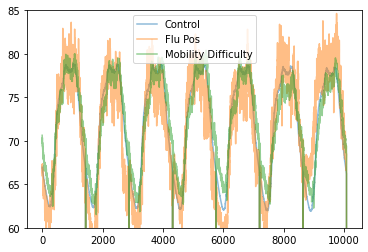

In [34]:
# plt.plot_date()
x = np.arange(len(group_means["mean(hr_vec)"].iloc[0]))
plt.plot(x,group_means.loc["None","mean(hr_vec)"],alpha=0.5, label="Control")
plt.plot(x,group_means.loc["flu_pos","mean(hr_vec)"],alpha=0.5, label="Flu Pos")
plt.plot(x,group_means.loc["mobility_difficulty","mean(hr_vec)"],alpha=0.5, label="Mobility Difficulty")
plt.gca().set_ylim([60,85])
plt.legend()

In [44]:
def scale(arr):
    std = np.std(arr)
    if not std==0:
        return (arr  - np.mean(arr)) / np.std(arr)
vector_scale = f.udf(scale, VectorUDT())
vec_df_scaled = vec_df.withColumn("scaled_hr",vector_scale(vec_df.hr_vec))
vec_df_scaled = vec_df_scaled.withColumn("scaled_steps",vector_scale(vec_df_scaled.steps_vec))
scaled_group_means = vec_df_scaled.groupby("group").agg(Summarizer.mean(vec_df_scaled.scaled_steps),
                            Summarizer.mean(vec_df_scaled.scaled_hr)).toPandas()


22/01/11 13:06:23 ERROR Executor: Exception in task 18.0 in stage 84.0 (TID 2739)
scala.MatchError: null
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:54)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:374)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:344)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:562)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:213)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:2

Py4JJavaError: An error occurred while calling o30599.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 18 in stage 84.0 failed 1 times, most recent failure: Lost task 18.0 in stage 84.0 (TID 2739) (darkwing.cs.washington.edu executor driver): scala.MatchError: null
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:54)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:374)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:344)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:562)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:213)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:207)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:158)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:77)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$2(ObjectHashAggregateExec.scala:107)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$2$adapted(ObjectHashAggregateExec.scala:85)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:885)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:885)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: scala.MatchError: null
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:54)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:374)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:344)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:562)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:196)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:213)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:207)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:158)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:77)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$2(ObjectHashAggregateExec.scala:107)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$2$adapted(ObjectHashAggregateExec.scala:85)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:885)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:885)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


22/01/11 13:06:23 WARN TaskSetManager: Lost task 5.0 in stage 84.0 (TID 2726) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 21.0 in stage 84.0 (TID 2742) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 31.0 in stage 84.0 (TID 2752) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 30.0 in stage 84.0 (TID 2751) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 26.0 in stage 84.0 (TID 2747) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 28.0 in stage 84.0 (TID 2749) (darkwing.cs.washington.edu executor driver): TaskKilled (Stage cancelled)
22/01/11 13:06:23 WARN TaskSetManager: Lost task 12.0 in stage 84.0 (TID 2733

In [42]:
scaled_group_means

,group,mean(scaled_steps),mean(scaled_hr)
0,None,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,mobility_difficulty,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,flu_pos,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
